In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import scipy
from IPython.display import display
import matplotlib.pyplot as plt

# Table of Contents <a name="contents"></a>
- [**1. Introduction**](#introduction)
    - [1.1. A Generative Model for Skill](#a_generative_model_for_skill)
    - [1.2. Outcome given Skills](#outcome_given_skills)
    - [1.3. Skills given Outcome, and the Evidence](#skills_given_outcome_and_the_evidence)
    - [1.4. Computing the Conditionals](#computing_the_conditionals)
- [**2. Load the Data**](#load_the_data)
- [**3. Gibbs Rank**](#gibbs_rank)
    - [3.1. Integration of an Intractable Posterior](#integration_of_an_intractable_posterior)
    - [3.2. Gibbs Sampling](#gibbs_sampling)
    - [3.3. Gibbs Sampling for TrueSkill](#gibbs_sampling_for_trueskill)
    - [3.4. Implementation](#implementation_gr)
    - [3.5. Iterations and Autocorrelation](#iterations_and_autocorrelation)
- [**4. Message Passing**](#message_passing)
    - [4.1. Inference and Factor Graphs](#inference_and_factor_graphs)
    - [4.2. The Sum-Product Algorithm](#the_sum_product_algorithm)
    - [4.3. Message Passing in TrueSkill](#message_passing_in_true_skill)
    - [4.4. Approximating Performance Marginals](#approximating_performance_marginals)
    - [4.5. Implementation](#implementation_mp)
- [**5. Analysis and Discussion**](#analysis_and_discussion)

# 1. Introduction <a name="introduction"></a>

Ranking systems have many different applications, however most common ones are poor as they rely on arbitrary conventions which lead to poor proformance. In general, they try to answer they question **What is the probability that player 1 defeats player 2?**. In order to determine this probabilistically, there are a number of things to consider:

- Considers who you played against.
- Must be robust against players who have not played against eachother.
- Give a good estimate at any point in the season.
- Take into account performance inconsistancy.

Therefore, what we want to infer is the player's **skill**, $w$. These skills must be comparable (i.e. a player with a higher skill must be more likely to win), and as such we want to do a probabilstic inference of a player's skill and be able to compute the probability of a game's outcome.

## 1.1. A generative model for skill <a name="a_generative_model_for_skill"></a>
[Back to Top](#contents)

A summary of a generative model for game outcomes can be defined as:

1. **Skills** Take two players with known skills, $$w_i \in \mathbb{R}$$
2. **Skill Difference**: $$s = w_1 - w_2$$
3. **Performance Difference**: Add noise ($n \sim \mathcal{N}(0, 1))$ to account for performance inconsistance: $$t = s + n$$
4. **Game outcome** is given by $y=sign(t)$:
    - $y = +1$ means player 1 wins
    - $y = -1$ means player 2 wins

![GenerativeModel](Figures/GenerativeModel.png)

The graph above shows part of the directed graph for the TrueSkill model. This encapsulates all of the conditional dependencies described above, and allows the joint distribution to be written as:

$$p(w_1, w_2, s_{12}, t_{12} | y_{12}) = \frac{p(w_1, w_2, s_{12}, t_{12}, y_{12})}{p(y)} = \frac{p(w_1)p(w_2)p(s_{12}|w_1, w_2)p(t_{12}|s_{12})p(y_{12}|t_{12})}{p(y)}$$

Note that this graphical model is described as "head-to-head" because the S nodes are at the head of at least two directed connections. A rule in graphical models is that if any "head-to-head" node, or any of its descendents, are observed, the path between parents nodes becomes "unblocked". I.e. the skills become dependent on eachother - which makes sense as we cannot determine one players skill without playing them against another.

The joint distribution given above is only a very small section of the whole joint distribution, which is almost circular in its dependencies (i.e. there is also an $s_{13}$ and an $s_{1,103}$, and so on - a different s for every game played).

We derive the probabilities above in subsequent sections. The aim of this notebook is to derive the marginal distributions $p(w)$ for all players.

## 1.2. Outcome given Skills <a name="outcome_given_skills"></a>
[Back to Top](#contents)
    
Therefore we can work out the probability that player 1 wins given the players skills':

$$p(y| w_1, w_2) = \int \int p(y|t) p(t|s) p(s | w_1, w_2) dsdt$$
$$ = \int p(y|t) p(t|w_1, w_2) dt$$
$$ = \int^{+\infty}_{-\infty} \delta(y - sign(t)) \mathcal{N}(t; w_1 - w_2, 1) dt$$
$$ = \int^{+\infty}_{-\infty} \delta(1 - sign(yt)) \mathcal{N}(yt; y(w_1 - w_2), 1) dt $$
set z = yt and note the change in limits and dt:
$$ = \int^{+y\infty}_{-y\infty} \delta(1 - sign(z)) \mathcal{N}(z; y(w_1 - w_2), 1) y dz $$
$$ = \int^{+\infty}_{-\infty} \delta(1 -sign(z)) \mathcal{N}(z; y(w_1 - w_2), 1) dz $$
And rearrange the limits:
$$ = \int^{+\infty}_{0} \mathcal{N}(z; y(w_1 - w_2), 1) dz $$
using $x = y(w_1-w_2) - z$
$$ = \int^{y(w_1 - w_2)}_{-\infty} \mathcal{N}(x; 0, 1) dx $$
$$ = \Phi(y(w_1 - w_2))$$

where $\Phi(a)$ is the gaussian c.d.f, or the *probit* function.

For the probability of player 1 winning, we simply use $p(y=1| w_1, w_2) = p(t>0| w_1, w_2) = \Phi(w_1 - w_2)$

![PerformanceDifference](Figures/PerformanceDifference.jpg)

## 1.3. Skills Given Outcome, and the Evidence <a name="skills_given_outcome_and_the_evidence"></a>
[Back to Top](#contents)

$$p(w_1, w_2 | y) = \frac{Priors \times Likelihood}{Evidence}$$
<br>
$$ = \frac{p(w_1)p(w_2) \times p(y|w_1, w_2)}{\int \int p(w_1)p(w_2) \times p(y|w_1, w_2) dw_1 dw_2}$$
<br>
$$ = \frac{\mathcal{N}(w_1; \mu_1, \sigma_1^2) \mathcal{N}(w_2; \mu_2, \sigma_2^2) \times \Phi(y(w_1 - w_2))}{\int \int \mathcal{N}(w_1; \mu_1, \sigma_1^2) \mathcal{N}(w_2; \mu_2, \sigma_2^2) \times \Phi(y(w_1 - w_2)) dw_1 dw_2}$$

The joint posterior over skills does not have a closed form as the probit function is not closed. Additionally, $w_1$ and $w_2$ have become correlated due to the priors and therefore does not factorise, nor is it a gaussian density function.

Fortunately, the evidence does have a closed form:

$$p(y) = \int \int \mathcal{N}(w_1; \mu_1, \sigma_1^2) \mathcal{N}(w_2; \mu_2, \sigma_2^2) \times \Phi(y(w_1 - w_2)) dw_1 dw_2 = \Phi \bigg(\frac{y(\mu_1 - \mu_2)}{\sqrt{1 + \sigma_1^2 + \sigma_2^2}} \bigg)$$

This is effectively a smoother version of the likelihood as we are using mean skills of each player, and normalising over their variances.

## 1.4. Computing the Conditionals <a name="computing_the_conditionals"></a>
[Back to Top](#contents)

For notation we have have $g = \{1, ..., G\}$ games where $I_g$ is the id of player 1, and $J_g$ is the id of player 1. The outcome of game g is:

$$y_g = \bigg{\{} \begin{array}{c} +1 \; if \; I_g \; wins \\ -1 \; if \; J_g \; wins \end{array}$$

Note also that the vector of skills is $\boldsymbol{w} = [w_1, ..., w_d]^T$, (d=107 players) and the vector of performance differences is $\boldsymbol{t} = [t_1, ..., t_G]^T$.

In **True Skill** the joint distribution $p(w_{1:d}, t_{1:G})$ is intractable. However, the two conditionals are tractable and easily derived to be:

- **Performance given skill difference**: $p(t_g | w_{I_g}, w_{J_g}, y_g) \propto \delta(y_g - sign(t_g)) \mathcal{N}(t_g;  w_{I_g} - w_{J_g}, 1)$
- **Skills given performances**: $p( \boldsymbol{w} | \boldsymbol{t}, \boldsymbol{y}) = p( \boldsymbol{w} | \boldsymbol{t}) \propto p(\boldsymbol {w}; \boldsymbol{\mu}_0, \Sigma_0) \prod_{g=1}^G \mathcal{N}(\boldsymbol{w}; \boldsymbol{\mu}_g, \Sigma_g)$

In order to calculate these, we can take the performance difference directly from the derivation of the evidence:

$$p(t | w_1, w_2, y) = p(y|t) p(t|w_1, w_2) = \delta(y - sign(t)) \mathcal{N}(t; w_1 - w_2, 1) dt$$

and similarly, we note that the priors for skill are $p(w_i) = \mathcal{N}(w_i | u_i, \sigma_i^2) \implies p(\boldsymbol{w}) = \prod_{i=1}^d p(w_i) = \mathcal{N}(\boldsymbol{w} ; \boldsymbol{\mu}_0, \Sigma_0)$. Thus,

$$p( \boldsymbol{w} | \boldsymbol{t}) = \frac{p(\boldsymbol{w})p(\boldsymbol{t}| \boldsymbol{w})}{p(\boldsymbol{t})} \propto p(\boldsymbol{w}) \prod_{g=1}^G p(t_g | w_{I_g}, w_{J_g}) = \mathcal{N}(\boldsymbol{w} ; \boldsymbol{\mu}_0, \Sigma_0) \prod_{g=1}^G \mathcal{N}(\boldsymbol{w}; \boldsymbol{\mu}_g, \Sigma_g)
$$

# 2. Load the Data <a name="load_the_data"></a>
[Back to Top](#contents)

In [2]:
import scipy.io
mat = scipy.io.loadmat('tennis_data.mat')

In [3]:
PLAYERS = pd.DataFrame(mat['W'], columns=['name']).applymap(lambda x: x[0])  # remove the list around each players name
GAMES = pd.DataFrame(mat['G']-1, columns=['winner', 'loser'])  # -1 because player num starts from 1 in matlab
display(PLAYERS.head(), GAMES.head())
display(len(PLAYERS), len(GAMES))

,name
0,Rafael-Nadal
1,Juan-Monaco
2,Juan-Martin-Del-Potro
3,Mardy-Fish
4,Roger-Federer


,winner,loser
0,0,1
1,0,2
2,0,2
3,0,2
4,0,2


107

1801

# 3. Gibbs Rank <a name="gibbs_rank"></a>

## 3.1. Integration of an Intractable Posterior <a name="integration_of_an_intractable_posterior"></a>
[Back to Top](#contents)

The basis of Monte-Carlo approximation is:
$$\mathbb{E}_{p(x)} \big[ \Phi(x) \big] \approx \hat{\Phi} = \frac{1}{T} \sum^t_{\tau = 1} \Phi(x^{(\tau)}), \text{  where } x^{(\tau)} \sim p(x)$$

Note that $x^{(\tau)}$ is the $\tau$th d-dimensional sample from the distribution p(x), which is analytically intractable (and typically d>>1).

This is infact an unbiased estimate, with $Var[\hat{\Phi}] = \frac{Var[\Phi]}{T}$. Note $Var[\Phi] = \int (\Phi(x) - \mathbb{E}[\Phi])^2 p(x) dx$. Note that this is independent of dimension d, of x.


How do we generate samples from p(x)? If the distribution has a standard form then we could generate independent samples, however, it is often difficult to sample from this joint distribution if it is within a high dimensional space (the curse of dimensionality). In order to get around this we can use **Gibbs Sampling**, which uses a Markov Chain to generate dependent samples from the desired distribution:

$$x_i' \sim  p(x_i | x_{1, 2, ..., i-1, i+1, ..., d})$$

## 3.2. Gibbs Sampling <a name="gibbs_sampling"></a>
[Back to Top](#contents)

Gibbs sampling assumes that we know the forms of the joint and conditional distributions. Given that $p(x, y) \propto p(x|y)$, we can thus sample from the conditional distributions. E.g. A number of experiments, k, are performed where we flip a coin n times (unknown). The coin is biased such that $p(heads) = \theta$.

- $n \sim U(5, 8)$
- $\theta \sim U(0, 1) = beta(1, 1)$

This gives us a sequence with the number of heads that were thrown: $X = (x_1, x_2, .., x_k)$. We are aiming to find $p(n, \theta | X) \propto p(X | n, \theta)p(n, \theta) = Zp(X | n, \theta)$. 

$$p(n, \theta | X) \propto \prod^k_{i=1} C^n_{x_i} \theta^{x_i} (1-\theta)^{n-x_i}$$
$$= \theta^{\sum+_{i=1}^k x_i}(1-\theta)^{\sum_{i=1}^k n-x_i} \prod_{i=1}^k  C^n_{x_i}$$
$$\theta^k\hat{x}(1-\theta)^{k(n-\hat{x})} \prod_{i=1}^k  C^n_{x_i}$$

Above is the joint probability upto a constant of proportionality. Next we need to find the conditionals, which we can do by simply splitting the above into $f_1(n)f_2(\theta)$.

$$p(\theta |n, X) \propto \theta^k\hat{x}(1-\theta)^{k(n-\hat{x})} = beta(k\hat{x}+1, k(n-\hat{x})+1)$$
$$p(n |\theta, X) \propto (1-\theta)^{kn}\prod_{i=1}^k  C^n_{x_i}$$

Note that there is no "nice" form for $p(n | \theta, X)$ here. But what we can do, is we know $n \in \{5, 6, 7, 8\}$, so we can use these values and sum them up to get a categorical distribution by normalising with them.

Gibbs sampling here then works simply by choosing some random starting point and then iteratively sampling from each of these two conditionals.

## 3.3. Gibbs Sampling for TrueSkill <a name="gibbs_sampling_for_trueskill"></a>
[Back to Top](#contents)

For **our problem**, we have 107 different players, and hence are sampling from 107 different conditional distributions for thier skills. Consider the distribution $p(x) = p(x_{1:d})$. The gibbs sampling algorithm is as follows:


> 1. Initialise $\{x_i : i = 1, .., d\}$
> 2. For $\tau = 1, ..., T$: <br>
    > &nbsp;&nbsp;&nbsp;&nbsp; For $i = 1, ..., d$: <br>
        > &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample $x_{i}^{\tau+1} \sim p(x_i|x_{\backslash i}^{(\tau)})$
        
**Try over-relaxation?**

![GibbsSampling](Figures/GibbsSampling.jpg)

Above is an illustration of Gibbs sampmling by alternate updates of two variables, whose distribution is a correlated GAussian. The step size is govened by the standard deviation of the  <span style="color:green">condiditional distribution</span>, and is O(l), leading to slow progression in the direction of elongation of the <span style="color:red">joint distribution</span>. The number of steps needed to obtain an independent sample from the distribution is $O((\frac{L}{l})^2)$. I.e. **Strong correlations slow down gibbs sampling**.

In **True Skill** the joint distribution $p(w_{1:d}, t_{1:G})$ is intractable. However, the two conditionals are tractable and have already been derived to be:

- **Performance given skill difference**: $p(t_g | w_{I_g}, w_{J_g}, y_g) = \frac{p(y|t) p(t|w_1, w_2)}{p(y)} \propto \delta(y_g - sign(t_g)) \mathcal{N}(t_g;  w_{I_g} - w_{J_g}, 1)$
- **Skills given performances**: $p( \boldsymbol{w} | \boldsymbol{t}, \boldsymbol{y}) = p( \boldsymbol{w} | \boldsymbol{t}) \propto p(\boldsymbol{w}) \prod_{g=1}^G p(t_g | w_{I_g}, w_{J_g})  =  p(\boldsymbol {w}; \boldsymbol{\mu}_0, \Sigma_0) \prod_{g=1}^G \mathcal{N}(\boldsymbol{w}; \boldsymbol{\mu}_g, \Sigma_g)$

We can describe the two above distributions in more detail:

#### For the conditional posterior of skills (skills given performances) we get:

$$p(t_g|w_{I_g}, w_{J_g}) = \mathcal{N}(t_g; (w_{I_g} - w_{J_g}), 1) \propto exp(-\frac{1}{2}(t_g-(w_{I_g} - w_{J_g}))^2 )$$

renaming $t_g = \mu_1 - \mu_2$

$$\propto exp(-\frac{1}{2}((w_{I_g} - \mu_1) - ( w_{J_g} - \mu_2) )^2 )$$

$$ \propto exp \bigg( -\frac{1}{2} 
\left[\begin{array}{c} w_{I_g} - \mu_1 \\ w_{J_g} - \mu_2 \end{array}\right]
\left[\begin{array}{cc} 1 & -1 \\ -1 & 1 \end{array}\right]
\left[\begin{array}{c} w_{I_g} - \mu_1 \\ w_{J_g} - \mu_2 \end{array}\right] \bigg)
$$

Recall that when multiplying gaussians, the precisions add up and the means weighted by the precisions also add up:

- $\Sigma_c^{-1} = \Sigma_a^{-1} + \Sigma_b^{-1}$
- $\mu_c = \Sigma_c(\Sigma_a^{-1}\mu_a +  \Sigma_b^{-1} \mu_b)$

Thus:

$$p(\boldsymbol {w}; \boldsymbol{\mu}_0, \Sigma_0) \prod_{g=1}^G \mathcal{N}(\boldsymbol{w}; \boldsymbol{\mu}_g, \Sigma_g) = \mathcal{N}(\boldsymbol{w}; \mu, \Sigma)$$

Where each game precision, $\Sigma_g^{-1}$ contains only 4 non-zero entries, the full precisions and means are:

- $\Sigma^{-1} = \Sigma_0^{-1} + \sum_{g=1}^G \Sigma_g^{-1}  = \Sigma_0^{-1} + \tilde{\Sigma}^{-1}$
- $\mu = \Sigma(\Sigma_0^{-1}\mu_0 + \sum_{g=1}^G \Sigma_g^{-1}\mu_g) = \Sigma(\Sigma_0^{-1}\mu_0 + \tilde{\mu})$

defining these further:

$$\tilde{\mu}_i = \sum_{g=1}^G t_g(\delta(i-I_g) - \delta(i-J_g))$$


$$ [ \tilde{\Sigma}^{-1} ]_{ij}  = \bigg\{  \begin{array}{c} \sum_{g=1}^G \delta(i-I_g) + \delta(i-J_g) \; \; \; for \; i = j \\ \sum_{g=1}^G \delta(i-I_g)\delta(j-J_g) + \delta(i-J_g)\delta(j-I_g) \; \; \; for \; i \neq j  \end{array} $$

The conditional skills can be jointly sampled directly using the cholesky factorization.

#### For the conditional posterior of the performances (performance given skill difference), 

we get a truncated gaussian that needs no further analysis, however the question becomes how do we sample from it? The inverse transformation method, or rejection sampling are both possibilities.

## 3.4. Implementation <a name="implementation_gr"></a>
[Back to Top](#contents)

In [4]:
def gibbs_sampler(total_iters, players=PLAYERS, games=GAMES):
    num_players, num_games = len(players), len(games)
    
    skill_samples = np.zeros(shape=(num_players, total_iters))
    prior_skill_vars = 0.5*np.ones(shape=(num_players))
    skills = np.zeros(shape=(num_players))
    
    for i in range(total_iters):
        ##### 1. SAMPLE p(performance_diffs | skills, outcomes)
        p_diffs = np.zeros(shape=(num_games))  # one peformance diff for each game
        for g in range(num_games):
            skill_diff = skills[games.at[g, 'winner']] - skills[games.at[g, 'loser']]
            
            # rejection sampling. Only positive performance diffs are accepted
            p_diffs[g] = skill_diff + np.random.randn()
            while p_diffs[g] < 0:
                p_diffs[g] = skill_diff + np.random.randn()
                   
        ##### 2. SAMPLE p(skills | performance_diffs)
        skills_mean = np.zeros(shape=(num_players))
        for p in range(num_players):
            skills_mean[p] = np.dot(p_diffs, ((games['winner'] - p) == 0).astype(np.int32) - ((games['loser'] - p) == 0).astype(np.int32))            
        
        skills_precision = np.zeros(shape=(num_players, num_players))
        for g in range(num_games):
            skills_precision[games.at[g, 'winner'], games.at[g, 'winner']] += 1
            skills_precision[games.at[g, 'loser'], games.at[g, 'loser']] += 1
            skills_precision[games.at[g, 'winner'], games.at[g, 'loser']] -= 1
            skills_precision[games.at[g, 'loser'], games.at[g, 'winner']] -= 1 
        skills_precision = np.diag(1.0 /prior_skill_vars) + skills_precision
        
        # cholesky decomposition of the precision matrix so we can sample from a multivariate gaussian
        chol = scipy.linalg.cho_factor(skills_precision) # (107x107 upper tri chol decomp, bower=false)
        mu = scipy.linalg.cho_solve(c_and_lower=chol, b=skills_mean, check_finite=False) # solve C.mu=b, mu=107x0
        sample = mu + scipy.linalg.solve_triangular(chol[0], np.random.randn(num_players, 1), check_finite=False).flatten() # 107x107
        
        skill_samples[:, i] = sample
        
    return skill_samples

In [5]:
%%time
skill_samples = gibbs_sampler(1100)
skill_samples = pd.DataFrame(data=skill_samples.T, columns=PLAYERS['name'])
display(skill_samples.describe()) # there are tot_iters rows and each row is a person

name,Rafael-Nadal,Juan-Monaco,Juan-Martin-Del-Potro,Mardy-Fish,Roger-Federer,Jo-Wilfried-Tsonga,Guillermo-Garcia-Lopez,Florian-Mayer,Milos-Raonic,Santiago-Giraldo,...,Juan-Sebastian-Cabal,Colin-Fleming,Santiago-Gonzalez,Marc-Lopez,Rohan-Bopanna,Michael-Kohlmann,Simon-Aspelin,Mikhail-Elgin,Robert-Lindstedt,Jean-Julien-Rojer
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,...,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,0.770247,0.140032,0.429435,0.318631,0.763503,0.456898,-0.177877,0.304470,0.234302,-0.004242,...,-0.530285,-0.207074,0.020681,-0.058819,-0.400624,-0.391625,-0.264319,-0.640169,-0.207885,-0.465401
std,0.157335,0.180520,0.172838,0.163340,0.155573,0.151095,0.207558,0.173053,0.202960,0.182973,...,0.559224,0.626409,0.549997,0.559068,0.458764,0.612322,0.615139,0.422038,0.595585,0.635637
min,0.238480,-0.494954,-0.148668,-0.257389,0.197142,-0.033601,-0.867789,-0.225023,-0.349068,-0.680744,...,-2.277377,-2.165007,-1.709387,-1.905029,-2.159212,-2.649226,-2.279531,-2.269710,-2.478515,-2.520014
25%,0.668623,0.021301,0.312614,0.205733,0.660405,0.360807,-0.318106,0.181390,0.097126,-0.125107,...,-0.903555,-0.617271,-0.328221,-0.425494,-0.689294,-0.805175,-0.675296,-0.907930,-0.613821,-0.894656
50%,0.769765,0.135373,0.423791,0.318799,0.757105,0.459975,-0.171035,0.304130,0.228290,-0.002910,...,-0.523937,-0.196179,0.026402,-0.068130,-0.398151,-0.369401,-0.273521,-0.638605,-0.201639,-0.452675
75%,0.879099,0.258505,0.547166,0.430371,0.865483,0.557926,-0.036984,0.429767,0.362528,0.112156,...,-0.162533,0.208166,0.371330,0.338329,-0.078774,0.023673,0.139172,-0.350467,0.191552,-0.015780
max,1.307759,0.847477,1.057989,0.896926,1.230947,0.915153,0.584695,0.853587,0.976627,0.536089,...,1.494616,1.697672,1.721419,1.523298,1.111420,1.545048,1.967370,0.766754,1.972214,1.531299


Wall time: 3min 25s


## 3.5. Iterations and Autocorrelation <a name="iterations_and_autocorrelation"></a>
[Back to Top](#contents)

In [6]:
def plot_skill_vs_iter(skill_samples, players):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 4))  # preferred to plt.plot
    
    # use pandas to plot things... it's better than matplotlib
    skill_samples[players].plot(ax=ax, alpha=0.5)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Player Skill')

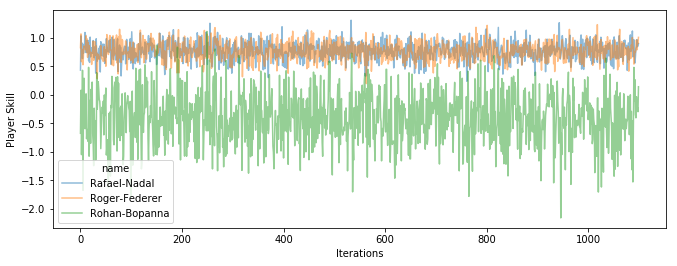

In [7]:
player_names=['Rafael-Nadal', 'Roger-Federer', 'Rohan-Bopanna']
plot_skill_vs_iter(skill_samples, player_names)

In [11]:
def plot_autocorrelations(skill_samples, players):
    max_lag=10    
    autocor = pd.DataFrame(columns=players, index=range(max_lag))
    
    for p in players:
        for i in range(max_lag):
            autocor.at[i, p] = pd.Series.autocorr(pd.Series(skill_samples[p].values), lag=i)
     
    autocor.plot()

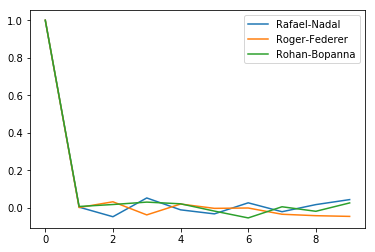

In [12]:
plot_autocorrelations(skill_samples, player_names)

In [10]:
def gaussian_distribution(x, mu, s):
    exponent = -0.5*((x-mu)/s)**2
    Z = (s * np.sqrt(2*np.pi))
    return np.exp(exponent) / Z

# 4. Message Passing <a name="message_passing"></a>

## 4.1. Inference and Factor Graphs <a name="inference_and_factor_graphs"></a>
[Back to Top](#contents)

Probability distributions often have conditional independence, and therefore, can be written in graphical form. Computing marginals of said distribution can be made much more efficient by taking advantage of the graphical model, simply by rearranging the order of summations and multiplications required.

We can write any joint distribution over a set of variables in the form of a product of factors:

$$ p(\boldsymbol{x}) = \prod_s f_s(\boldsymbol{x}_s) $$

where $\boldsymbol{x}_s$ denotes a subset of the variables. Each factor $f_s$ is a function of this set of variables. For example consider the graph:

![FactorGraph](Figures/FactorGraphExample.PNG)

This has a factorisation of

$$p(\boldsymbol{x}) = f_a(x_1, x_2)f_b(x_1, x_2)f_c(x_2, x_3)f_d(x_3)$$

We can convert a directed graph to a factor graph by simply creating variable
nodes in the factor graph corresponding to the nodes of the directed graph, and then
create factor nodes corresponding to the conditional distributions, and then finally
add the appropriate links. There can be multiple factor graphs all of which
correspond to the same directed graph.

![FactorGraph2](Figures/FactorGraphExample2.PNG)

The directed graph here corresponds to the factorisation:

$$p(x_1, x_2, x_3) = p(x_1)p(x_2)p(x_3|x_1, x_2)$$

And the factor graphs have factors equal to:
$$b) \;\; f(x_1, x_2, x_3) = p(x_1)p(x_2)p(x_3|x_1, x_2)$$
$$c) \;\; f_a(x_1) = p(x_1), \; f_b(x_2) = p(x_2), \; f_c(x_1, x_2, x_3) = p(x_3|x_1, x_2)$$

## 4.2. The Sum-Product Algorithm <a name="the_sum_product_algorithm"></a>
[Back to Top](#contents)

The Sum-Product algorithm is an exact inference method to compute node marginals in factor graphs. If the variables are discrete then marginalisation corresponds to preforming sums, whereas if we are working with linear gaussians then integration is used (e.g. linear dynamical systems). Note that there is a similar algorithm for directed graphs called "belief propagation", however, this is actually a special case of the sum-product algorithm, and so converting to a factor graph is better in general.

The sum-product algorithm can conveniently be interpreted as the passing of "messages". In general there are two types of message, which we will show with the examples below:

![MessagePassing](Figures/MessagePassing.png)

- **Messages from factors to variables** (left figure):  &nbsp; &nbsp; &nbsp; $m_{f\rightarrow x}(x)$ &nbsp; &nbsp; &nbsp; To evaluate the message from a factor node, evaluate the **sum** of all messages coming into the factor (i.e. from variables), except the message going to the variable of interest.

$$m_{f_s \rightarrow x}(x) = \sum_m^M m_{x_m \rightarrow f_s}(x_m)$$


- **Messages from variables to factors** (right figure):  &nbsp; &nbsp; &nbsp; $m_{x \rightarrow f}(x)$ &nbsp; &nbsp; &nbsp; To evaluate the message from a variable, evaluate the **product** of all messages coming into the variable (i.e. from factors), execpt the message going to the factor of interest.

$$m_{x_m \rightarrow f_s}(x_m) = \prod_l^L m_{f_l \rightarrow x_m}(x_m)$$

Each message comprises a set of K values (or a distribution if working with continuous variables), one for each choice of x_n, and so the product of two messages should be interpreted as the point-wise multiplication of the elements of the two messages to give another set of K values. Note, $F_s(x, X_s)$ represents the product of all the factors in the group associated with f_s, and similarly, $G_m(x_m, X_{sm})$is given by a product of terms $F_l(x, X_ml)$ each associated with one of the factor nodes $f_l$ that is linked to node $x_m$

We can derive expressions for the marginals of each node simply by finding the product of all incoming messages to that node:

$$p(x) = \prod_{s \in neighbours(x)} m_{f_s \rightarrow x}(x)$$

An example is given below to illustrate this: 

![SumProduct](Figures/SumProduct.png)

The graph above has an unnormalised joint distribution given by $\tilde{p}(\boldsymbol{x}) = f_a(x_1, x_2)f_b(x_2, x_3)f_c(x_2,x_4)$. In order to apply the sum-product algorithm to the graph we first designate a "root node" (it doesnt matter which one you choose) and then calculate the messages from the leaf nodes to the root node (fig. b) and then from the root node to the leaf nodes (fig c).

- **leaf to root messages**
$$m_{x_1 \rightarrow f_a}(x_1) = 1$$
$$m_{f_a \rightarrow x_2}(x_2) = \sum_{x_1} f_a(x_1, x_2)$$
$$m_{x_4 \rightarrow f_c}(x_4) = 1$$
$$m_{f_c \rightarrow x_2}(x_2) =  \sum_{x_4} f_c(x_2, x_4)$$
$$m_{x_2 \rightarrow f_b}(x_2) =  m_{f_a \rightarrow x_2}(x_2)m_{f_c \rightarrow x_2}(x_2)$$
$$m_{f_b \rightarrow x_3}(x_3) =  \sum_{x_2} f_b(x_2, x_3)m_{x_2 \rightarrow f_b}(x_2)$$

- **root to leaf messages**
$$m_{x_3 \rightarrow f_b}(x_3) = 1$$
$$m_{f_b \rightarrow x_2}(x_2) = \sum_{x_3} f_b(x_2, x_3)$$
$$m_{x_2 \rightarrow f_a}(x_2) = m_{f_b \rightarrow x_2}(x_2)m_{f_c \rightarrow x_2}(x_2)$$
$$m_{f_a \rightarrow x_1}(x_1) =  \sum_{x_2} f_a(x_1, x_2)m_{x_2 \rightarrow f_a}(x_2)$$
$$m_{x_2 \rightarrow f_c}(x_2) =  m_{f_a \rightarrow x_2}(x_2)m_{f_b \rightarrow x_2}(x_2)$$
$$m_{f_c \rightarrow x_4}(x_4) =  \sum_{x_2} f_c(x_2, x_4)m_{x_2 \rightarrow f_c}(x_2)$$

Note that each message has passed once in each direction across each link in the graph, and that the normalisation constant Z need only be evaluated once (using any convenient note). If the factor graph was derived from a directed graph, then the joint distribution is already correctly normalized, and so the marginals obtained by the sum-product algorithm will similarly be normalized correctly. However, if we started from an undirected graph, then in general there will be an unknown normalization coefficient 1/Z.

We can now calculate the marginal $\tilde{p}(x_2) = m_{f_a \rightarrow x_2}(x_2) m_{f_b \rightarrow x_2}(x_2) m_{f_c \rightarrow x_2}(x_2)$

$$\tilde{p}(x_2) = \left[ \sum_{x_1} f_a(x_1, x_2) \right]    \left[ \sum_{x_3} f_b(x_2, x_3) \right]    \left[ \sum_{x_4} f_c(x_2, x_4) \right]$$
$$ = \sum_{x_1} \sum_{x_2} \sum_{x_3}  f_a(x_1, x_2) f_b(x_2, x_3) f_c(x_2, x_4)$$
$$ = \sum_{x_1} \sum_{x_2} \sum_{x_3} \tilde{p}(\boldsymbol{x}) $$

If some nodes in the graph are observed, then the corresponding variables are simply clamped to their observed values and there is no summation.

## 4.3. Message Passing in TrueSkill <a name="message_passing_in_true_skill"></a>
[Back to Top](#contents)

In TrueSkill, the factor graph that is relevent to the directed graph given in section 1.1. is

![TrueSkillFactorGraph](Figures/FactorGraph.JPG)

We can easily read off what the factors in this graph are by looking at the directed graph:

- **Prior factors** $\;\;\; f_i(w_i) = \mathcal{N}(w_i; \mu_0, \sigma_0^2)$
- **Game factors** $\;\;\; h_g(w_{I_g}, w_{J_g}, t_g) = \mathcal{N}(t_g; w_{I_g}- w_{J_g}, 1)$
- **Outcome factors** $\;\;\; k_g(t_g, y_g) = \delta(y_g - sign(t_g))$

Note however, this TrueSkill graph isnt a tree and therefore we cannot do exact inference. We can, however, do iterative inference. Additionally, some of the messages don't have a standard form, and therefore we need to make some approximations. The whole process can be summarised as below:

![TrueSkillMP](Figures/TrueSKillMP.png)

Where the derivations for each step is given by:

![TrueSkillMPEquations](Figures/TrueSKillMPEquations.png)

## 4.4. Approximating Performance Marginals <a name="approximating_performance_marginals"></a>
[Back to Top](#contents)

The approximation of the performance marginals, $q^{\tau+1}(t_g) = Approx(m^{\tau}_{h_g \rightarrow t_g}(t_g)m_{k_g \rightarrow t_g}(t_g))$ is needed due to the game to performance message, $m_{k_g \rightarrow t_g}(t_g) = \delta(y_g-sign(t_g))$ effectively truncating the gaussian message sent in the message $m^{\tau}_{h_g \rightarrow t_g}(t_g)$. Thus, in order to keep the approximation of $p(t_g)$ as a gaussian, we approximate the product of these messages to get the approximate marginal $q(t_g)$. This is done by moment matching, which is illustrated below:

![MomentMatching](Figures/MomentMatching.JPG)

Moment matching is simply done by emperically finding the mean and variance of the truncated gaussian and then creating a new gaussian with the moments found by doing this.

Recall that the moments of a probability distribution are given by:

$$\mathbb{E}_{p(t)}[t^n] = \int^\infty_{-\infty}t^n p(t) dt$$

where $p(t)$ is given by

$$p(t) = \frac{1}{Z_t} \delta(t-sign(y))\mathcal{N}(t; \mu, \sigma^2)$$

where 
$$Z_t = \int^\infty_{-\infty} \delta(t-sign(y))\mathcal{N}(t; \mu, \sigma^2) dt =  \int^0_{-\infty} \mathcal{N}(t; -y\mu, \sigma^2) dt =  \int^{\frac{y\mu}{\sigma}}_{-\infty} \mathcal{N}(t; 0, 1) dt = \Phi \left(\frac{y\mu}{\sigma} \right) $$

Thus we are trying to solve

- $\mathbb{E}_{p(t)}[t] = \frac{1}{Z_t} \int^\infty_{-\infty}t  \delta(t-sign(y))\mathcal{N}(t; \mu, \sigma^2) dt =  \frac{1}{Z_t} \int^\infty_0 t  \mathcal{N}(t; y \mu, \sigma^2) dt$
- $\mathbb{E}_{p(t)}[t^2] = \frac{1}{Z_t} \int^\infty_{-\infty} t^2  \delta(t-sign(y))\mathcal{N}(t; \mu, \sigma^2) dt = \frac{1}{Z_t} \int^\infty_0 t^2  \mathcal{N}(t; y \mu, \sigma^2) dt$

**For the first moment**, a key insight is that we can take the two different forms of the proportionality constant above to get the mean, simply by differentiating wrt $\mu$:

$$(1) \;\;\;\;\;\; \frac{\partial}{\partial \mu} Z_t =  \int^0_{-\infty} \frac{\partial}{\partial \mu} \mathcal{N}(t; -y\mu, \sigma^2) dt $$

$$ = \int^0_{-\infty} -y\frac{t+y\mu}{\sigma^2} \mathcal{N}(t; -y\mu, \sigma^2) dt $$

$$ = \frac{yZ_t}{ \sigma^2} \int^\infty_{-\infty} (t-y\mu) p(t) dt $$

noting that $y^2 = 1$, and that the integral above is the expectation $\mathbb{E}_{p(x)}[t-y\mu]$

$$\frac{\partial}{\partial \mu} Z_t =  \frac{yZ_t }{\sigma^2}\mathbb{E}_{p(x)}[t] - \frac{\mu Z_t }{\sigma^2} $$

$$(2) \;\;\;\;\;\; \frac{\partial}{\partial \mu} Z_t = \frac{\partial}{\partial \mu} \Phi(\frac{y\mu}{\sigma}) = y \mathcal{N}(y\mu; 0, \sigma^2) = \frac{y}{\sigma} \mathcal{N}(\frac{y\mu}{\sigma}; 0, 1)$$

Putting these together gives us an expression for $\mathbb{E}_{p(x)}[t]$:

$$y\mathbb{E}_{p(x)}[t] - \mu = \frac{y\sigma}{Z_t} \mathcal{N}(\frac{y\mu}{\sigma}; 0, 1) $$

Noting that $y^{-1} = y$ we get:

$$\mathbb{E}_{p(x)}[t] = y\mu + \frac{\sigma}{Z_t} \mathcal{N}(\frac{y\mu}{\sigma}; 0, 1) $$

**For the second moment** we can use a similar trick by differentiating $Z_t$ again wrt $\mu$. 

$$(1) \;\;\;\;\;\; \frac{\partial^2}{\partial \mu^2} Z_t = \frac{\partial}{\partial \mu} \int^0_{-\infty} -y \frac{t+y\mu}{\sigma^2} \mathcal{N}(t; -y\mu, \sigma^2) dt = \frac{\partial}{\partial \mu} \int^\infty_{0} y \frac{t-y\mu}{\sigma^2} \mathcal{N}(t; y\mu, \sigma^2) dt $$

$$= \frac{y}{\sigma^2} \int^\infty_{0}  t \frac{\partial}{\partial \mu} \mathcal{N}(t; y\mu, \sigma^2) dt - \frac{y^2}{\sigma^2} \int^\infty_{0}  \frac{\partial}{\partial \mu} \mu \mathcal{N}(t; y\mu, \sigma^2) dt$$

$$= \frac{y}{\sigma^2} \int^\infty_0 y t\frac{t-y\mu}{\sigma^2} \mathcal{N}(t; y\mu, \sigma^2) dt - \frac{1}{\sigma^2} \int^\infty_{0} \mathcal{N}(t; y\mu, \sigma^2)  + y\mu \frac{t-y\mu}{\sigma^2} \mathcal{N}(t; y\mu, \sigma^2) dt$$

Substituting in the results from $\frac{\partial Z_t}{\partial \mu}$, and $Z_t$ derived above, we get

$$= \frac{y^2}{\sigma^4} \int^\infty_0 t (t-y\mu) \mathcal{N}(t; y\mu, \sigma^2) dt - \frac{1}{\sigma^2} (Z_t  + \mu \frac{\partial Z_t}{\partial \mu})$$


## 4.5. Implementation <a name="implementation_mp"></a>
[Back to Top](#contents)

In [11]:
function [Ms_container, Ps_container] = MPA(totIters, W, G, param1, param2)

    NumPlayers = size(W,1);            % number of players
    NumGames = size(G,1);            % number of games in 2011 season 

    psi = inline('normpdf(x)./normcdf(x)');
    lambda = inline('(normpdf(x)./normcdf(x)).*( (normpdf(x)./normcdf(x)) + x)');
    pv = 0.5;            % prior skill variance (prior mean is always 0)

    % initialize matrices of skill marginals - means and precisions
    Ms = nan(NumPlayers,1);
    Ps = nan(NumPlayers,1);
    % initialize matrices of game to skill messages - means and precisions
    Mgs = param1.*ones(NumGames,2);        Pgs = param2.*ones(NumGames,2); % (originally zeros(NumGames, 2))

    % allocate matrices of skill to game messages - means and precisions
    Msg = nan(NumGames,2);             Psg = nan(NumGames,2);
    
    % initialize Containers for marginal skills
    temp_Ms_container = nan(numel(Ms(:, 1)), totIters); %creates a column for each iter
    temp_Ps_container = nan(numel(Ps(:, 1)), totIters); %rows are player number
    
    %iter = 1;      % max_belief_change = 1;
    for iter = 1:totIters % && (max_belief_change < tol)
      % (1) compute marginal skills 
      for p=1:NumPlayers
        % precision first because it is needed for the mean update
        Ps(p) = 1/pv + sum(Pgs(G==p)); 
        Ms(p) = sum(Pgs(G==p).*Mgs(G==p))./Ps(p);
      end

      % (2) compute skill to game messages
      % precision first because it is needed for the mean update
      Psg = Ps(G) - Pgs;
      Msg = (Ps(G).*Ms(G) - Pgs.*Mgs)./Psg;

      % (3) compute game to performance messages
      vgt = 1 + sum(1./Psg, 2);
      mgt = Msg(:,1) - Msg(:,2); % player 1 always wins the way we store data

      % (4) approximate the marginal on performance differences
      Mt = mgt + sqrt(vgt).*psi(mgt./sqrt(vgt));
      Pt = 1./( vgt.*( 1-lambda(mgt./sqrt(vgt)) ) );

      % (5) compute performance to game messages
      ptg = Pt - 1./vgt;
      mtg = (Mt.*Pt - mgt./vgt)./ptg;   

      % (6) compute game to skills messages
      Pgs = 1./(1 + repmat(1./ptg,1,2) + 1./Psg(:,[2 1]));
      Mgs = [mtg, -mtg] + Msg(:,[2 1]);
      
      temp_Ms_container(:, iter) = Ms;
      temp_Ps_container(:, iter) = Ps;
      %iter = iter+1;
    end
    Ms_container = temp_Ms_container;
    Ps_container = temp_Ps_container;
end


IndentationError: unexpected indent (<ipython-input-11-d362cfe33fb2>, line 3)